In [12]:
import torch
from transformers import AutoTokenizer

import shap
import random
import pandas as pd
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model, prepare_data
from TRC.utils_ea import create_token_dict, get_top_n

In [13]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [14]:
train_data_path = '/home/cc/rora_tesi_new/data/train.p'
test_data_path = '/home/cc/rora_tesi_new/data/test.p'

need_columns = ['tweet','tweet_tokens', 'sentence_class']

tweet_test, tweet_tokens_test, binary_test = prepare_data(test_data_path, need_columns)

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# labels = sorted(model.config.label2id, key=model.config.label2id.get)
# print(labels)
# labels = [x.split('_')[1] for x in labels]
# print(labels)

In [17]:
# input della funzione una lista di stringhe

def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [18]:
random.seed(42)
random_indices = random.sample(range(len(tweet_test)), 50)
inputs = tweet_test[random_indices]

In [19]:
# inputs = []
# for i in range(10):
#     inputs.append(tweet_test[i])

In [20]:
explainer = shap.Explainer(f, masker = tokenizer)

In [21]:
shap_values = explainer(inputs)
shap_values.shape

Partition explainer: 51it [03:13,  3.94s/it]                        


(50, None, 2)

In [22]:
token_dict = create_token_dict(shap_values)

In [23]:
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

In [24]:
to_plot = get_top_n(20, sorted_d)

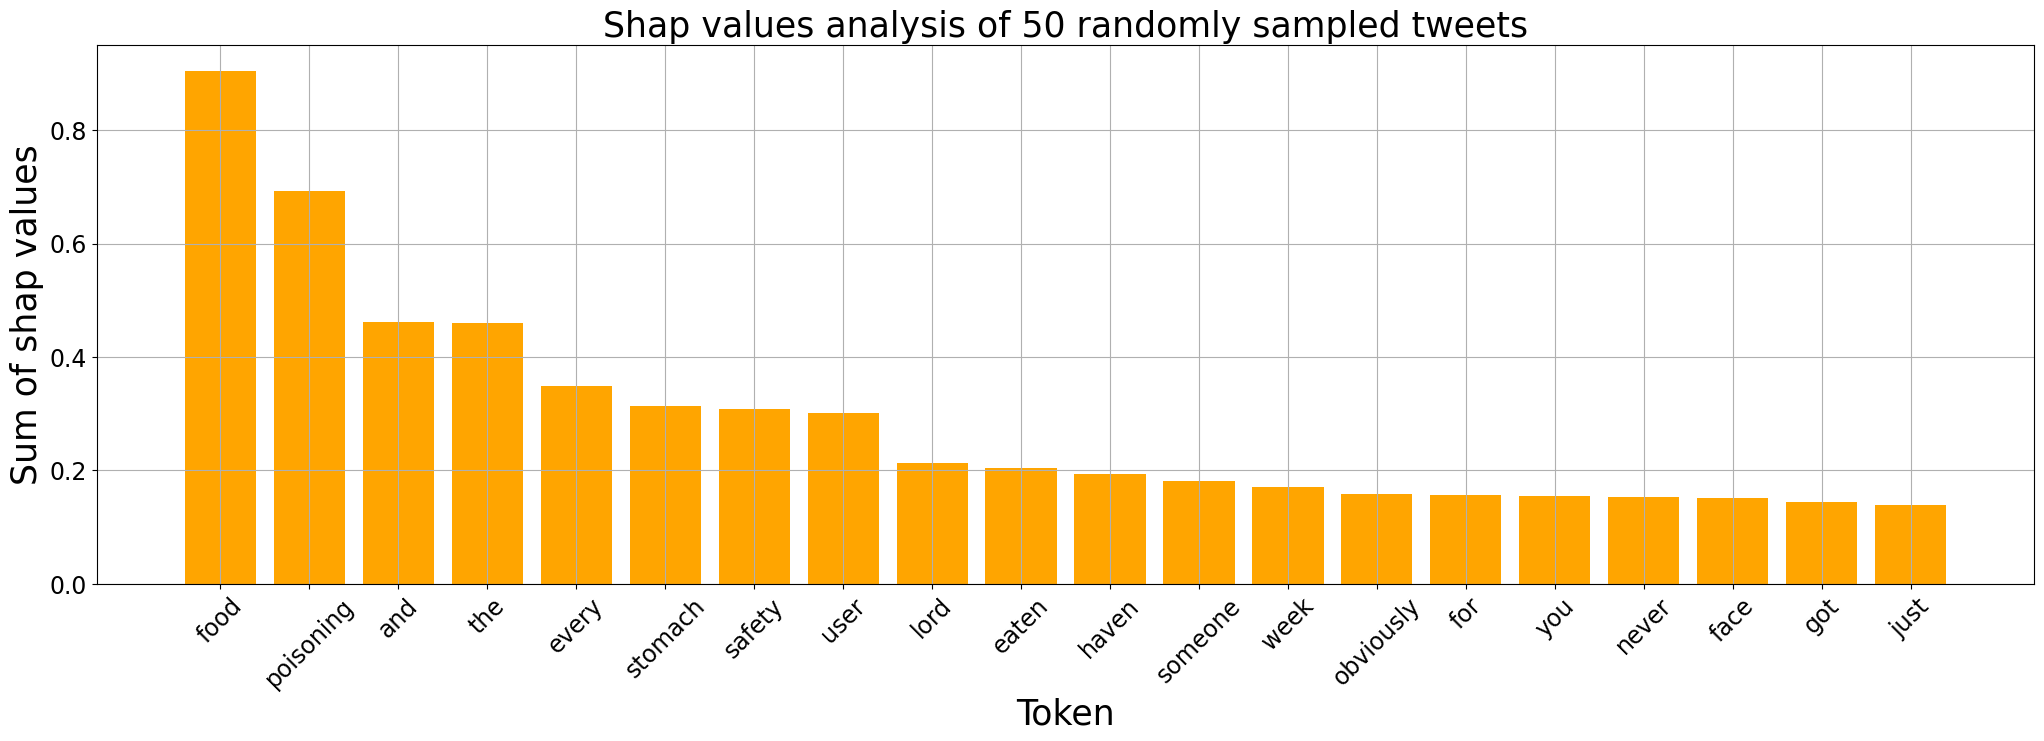

In [31]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'orange')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis of 50 randomly sampled tweets', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
plt.savefig('shap_50_rnd.png',bbox_inches='tight')
plt.show()